# Evo 2 and Helix-mRNA Comparison

## In this notebook we are going to use Evo 2 and Helix-mRNA on a zero-shot mRNA downstream task to predict mRFP Expression

- The installation to use the Evo 2 model is slightly tricky, but we have made guides on how to install it pain free in `helical/models/evo_2/README.md` using either a docker image or a conda environment
- A few things to note before attempting to run Evo 2
    - Evo 2 requires NVIDIA GPUs with compute capability ≥8.9
    - It has to be run on an x86_64 system
    - We run it on Ubuntu 22.04.5 LTS

### Once you have installed everything you can continue with the notebook!

- Make sure you have installed all requirements for Evo 2 before running this since we have it as a separate installation to the main package
- These can be found in the `[evo-2]` of the `helical/pyproject.toml`

**Imports and Installs**

In [ ]:
!pip install evaluate

In [1]:
from helical.models.evo_2 import Evo2, Evo2Config
from helical.models.helix_mrna import HelixmRNA, HelixmRNAConfig
import subprocess
import numpy as np
from sklearn.linear_model import LinearRegression
import pandas as pd
import umap
import umap.plot
from sklearn.neighbors import NearestNeighbors
import umap.umap_
import evaluate
from sklearn.neural_network import MLPRegressor

**Download a CodonBERT task dataset**

In [ ]:
url = "https://raw.githubusercontent.com/Sanofi-Public/CodonBERT/refs/heads/master/benchmarks/CodonBERT/data/fine-tune/mRFP_Expression.csv"

output_filename = "mRFP_Expression.csv"
wget_command = ["wget", "-O", output_filename, url]

try:
    subprocess.run(wget_command, check=True)
    print(f"File downloaded successfully as {output_filename}")
except subprocess.CalledProcessError as e:
    print(f"Error occurred: {e}")

In [3]:
dataset = pd.read_csv(output_filename)
train_data = dataset[dataset["Split"] == "train"]
eval_data = dataset[dataset["Split"] == "val"]
test_data = dataset[dataset["Split"] == "test"]

**Defining our Helix-mRNA model**

In [4]:
helix_mrna_config = HelixmRNAConfig(device="cuda", batch_size=1, max_length=max(len(s) for s in train_data["Sequence"])+10)
helix_mrna = HelixmRNA(helix_mrna_config)

**Visualise the Helix-mRNA model architecture**

In [12]:
helix_mrna.model

HelixmRNAPretrainedModel(
  (embeddings): Embedding(14, 256)
  (layers): ModuleList(
    (0): Mamba2Block(
      (norm): Mamba2RMSNorm()
      (mixer): Mamba2Mixer(
        (act): SiLU()
        (conv1d): Conv1d(768, 768, kernel_size=(4,), stride=(1,), padding=(3,), groups=768)
        (in_proj): Linear(in_features=256, out_features=1296, bias=False)
        (norm): MambaRMSNormGated()
        (out_proj): Linear(in_features=512, out_features=256, bias=False)
      )
    )
    (1): HelixmRNAMLPLayer(
      (feed_forward): HelixmRNAMLP(
        (gate_proj): Linear(in_features=256, out_features=1024, bias=False)
        (up_proj): Linear(in_features=256, out_features=1024, bias=False)
        (down_proj): Linear(in_features=1024, out_features=256, bias=False)
        (act_fn): SiLU()
      )
      (input_layernorm): Mamba2RMSNorm()
    )
    (2): Mamba2Block(
      (norm): Mamba2RMSNorm()
      (mixer): Mamba2Mixer(
        (act): SiLU()
        (conv1d): Conv1d(768, 768, kernel_size=(4,)

**Process the data for Helix-mRNA**

In [5]:
helix_train_dataset = helix_mrna.process_data(train_data)
helix_eval_dataset = helix_mrna.process_data(eval_data)
helix_test_dataset = helix_mrna.process_data(test_data)

**Generate our Helix-mRNA embeddings**
- We then take a mean across all token embeddings for probing

In [6]:
helix_train_embeddings = helix_mrna.get_embeddings(helix_train_dataset)
helix_eval_embeddings = helix_mrna.get_embeddings(helix_eval_dataset)
helix_test_embeddings = helix_mrna.get_embeddings(helix_test_dataset)

helix_mean_train_embeddings = np.mean(helix_train_embeddings, axis=1)
helix_mean_eval_embeddings = np.mean(helix_eval_embeddings, axis=1)
helix_mean_test_embeddings = np.mean(helix_test_embeddings, axis=1)

Getting embeddings: 100%|██████████| 219/219 [00:00<00:00, 291.42it/s]


**Lets visualise the training embeddings**

<Axes: >

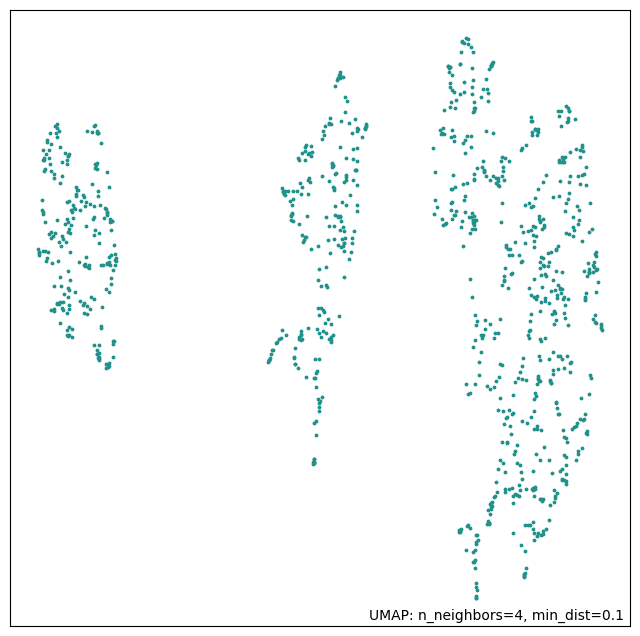

In [7]:
nbrs = NearestNeighbors(n_neighbors=4, metric='euclidean')
nbrs.fit(helix_mean_train_embeddings)
knn_dists, knn_indices = nbrs.kneighbors(helix_mean_train_embeddings)

reducer = umap.umap_.UMAP(
        n_neighbors=4,
        min_dist=0.1,
        n_components=2,
        metric='euclidean',
        random_state=0,
    )

mapper = reducer.fit(helix_mean_train_embeddings, knn_indices=knn_indices, knn_dists=knn_dists)

umap.plot.points(mapper, cmap='viridis')

**We can now create a model to predict mRFP expression based on the embeddings produced by Helix-mRNA**

In [10]:
helix_regr_linear = LinearRegression().fit(helix_mean_train_embeddings, train_data["Value"].to_numpy())
predicted_helix_linear = helix_regr_linear.predict(helix_mean_test_embeddings)

In [25]:
helix_regr = MLPRegressor(random_state=1, max_iter=2000, tol=0.001, activation='relu', verbose=True, batch_size=16)
helix_regr.fit(helix_mean_train_embeddings, train_data["Value"].to_numpy())
predicted_helical = helix_regr.predict(helix_mean_test_embeddings)

Iteration 1, loss = 29.01392398
Iteration 2, loss = 3.13285537
Iteration 3, loss = 0.25518598
Iteration 4, loss = 0.25415867
Iteration 5, loss = 0.25454147
Iteration 6, loss = 0.25209011
Iteration 7, loss = 0.25292553
Iteration 8, loss = 0.25091316
Iteration 9, loss = 0.25071903
Iteration 10, loss = 0.24906641
Iteration 11, loss = 0.24812479
Iteration 12, loss = 0.24812718
Iteration 13, loss = 0.24564484
Iteration 14, loss = 0.24480049
Iteration 15, loss = 0.24429613
Iteration 16, loss = 0.24368767
Iteration 17, loss = 0.24277831
Iteration 18, loss = 0.24062888
Iteration 19, loss = 0.23947988
Iteration 20, loss = 0.23790173
Iteration 21, loss = 0.23698493
Iteration 22, loss = 0.23609514
Iteration 23, loss = 0.23506544
Iteration 24, loss = 0.23440613
Iteration 25, loss = 0.23332754
Iteration 26, loss = 0.23386499
Iteration 27, loss = 0.23446553
Iteration 28, loss = 0.23303894
Iteration 29, loss = 0.23349216
Iteration 30, loss = 0.23030758
Iteration 31, loss = 0.22791974
Iteration 32, lo

MLPRegressor(batch_size=16, max_iter=2000, random_state=1, tol=0.001,
             verbose=True)

**Lets see the Spearman and Pearson correlations on the test set**

In [11]:
y_true = test_data["Value"].to_numpy()
spearmanr_metric = evaluate.load("spearmanr")
pearson_metric = evaluate.load("pearsonr")
results_spearman = spearmanr_metric.compute(references=y_true, predictions=predicted_helix_linear)
result_pearson = pearson_metric.compute(references=y_true, predictions=predicted_helix_linear)
print(f"Spearman: {results_spearman['spearmanr']}")
print(f"Pearson: {result_pearson['pearsonr']}")

Spearman: 0.5526808870405704
Pearson: 0.5627266697072656


**Defining our Evo 2 7B model**

In [4]:
evo2 = Evo2(Evo2Config(model_name="evo2-7b", batch_size=1))

100%|██████████| 32/32 [00:00<00:00, 85.33it/s]


Extra keys in state_dict: {'blocks.2.mixer.mixer.filter.t', 'blocks.16.mixer.mixer.filter.t', 'blocks.3.mixer.dense._extra_state', 'blocks.10.mixer.attn._extra_state', 'blocks.6.mixer.mixer.filter.t', 'blocks.20.mixer.mixer.filter.t', 'blocks.17.mixer.attn._extra_state', 'blocks.9.mixer.mixer.filter.t', 'blocks.17.mixer.dense._extra_state', 'blocks.23.mixer.mixer.filter.t', 'blocks.24.mixer.attn._extra_state', 'blocks.31.mixer.attn._extra_state', 'blocks.10.mixer.dense._extra_state', 'blocks.30.mixer.mixer.filter.t', 'blocks.27.mixer.mixer.filter.t', 'blocks.31.mixer.dense._extra_state', 'blocks.3.mixer.attn._extra_state', 'blocks.24.mixer.dense._extra_state', 'blocks.13.mixer.mixer.filter.t', 'unembed.weight'}


**Print the model architecture**

In [26]:
evo2.model

StripedHyena(
  (embedding_layer): VocabParallelEmbedding(512, 4096)
  (blocks): ModuleList(
    (0): ParallelGatedConvBlock(
      (pre_norm): RMSNorm()
      (post_norm): RMSNorm()
      (filter): HyenaCascade()
      (projections): TELinear()
      (out_filter_dense): Linear(in_features=4096, out_features=4096, bias=True)
      (mlp): ParallelGatedMLP(
        (l1): Linear(in_features=4096, out_features=11264, bias=False)
        (l2): Linear(in_features=4096, out_features=11264, bias=False)
        (l3): Linear(in_features=11264, out_features=4096, bias=False)
      )
    )
    (1-2): 2 x ParallelGatedConvBlock(
      (pre_norm): RMSNorm()
      (post_norm): RMSNorm()
      (filter): HyenaCascade()
      (projections): TELinear()
      (out_filter_dense): Linear(in_features=4096, out_features=4096, bias=True)
      (mlp): ParallelGatedMLP(
        (act): Identity()
        (l1): Linear(in_features=4096, out_features=11264, bias=False)
        (l2): Linear(in_features=4096, out_feat

**Process our data for input into the Evo 2 model**

In [6]:
train_data["Sequence"] = train_data["Sequence"].apply(lambda x: x.replace("U", "T"))
eval_data["Sequence"] = eval_data["Sequence"].apply(lambda x: x.replace("U", "T"))
test_data["Sequence"] = test_data["Sequence"].apply(lambda x: x.replace("U", "T"))

evo_train_dataset = evo2.process_data(train_data)
evo_eval_dataset = evo2.process_data(eval_data)
evo_test_dataset = evo2.process_data(test_data)

**Now we are going to generate embeddings for the different sequences using Evo 2**
- We then take a mean across all token embeddings for use on the downstream tasks

In [ ]:
evo_train_embeddings = evo2.get_embeddings(evo_train_dataset)
evo_eval_embeddings = evo2.get_embeddings(evo_eval_dataset)
evo_test_embeddings = evo2.get_embeddings(evo_test_dataset)

evo_mean_train_embeddings = np.mean(evo_train_embeddings["embeddings"], axis=1)
evo_mean_eval_embeddings = np.mean(evo_eval_embeddings["embeddings"], axis=1)
evo_mean_test_embeddings = np.mean(evo_test_embeddings["embeddings"], axis=1)
evo_mean_train_embeddings.shape, evo_mean_eval_embeddings.shape, evo_mean_test_embeddings.shape

((1021, 4096), (219, 4096), (219, 4096))

**Save our embeddings so we do not need to rerun the model every time**

In [22]:
np.savez("train_embeddings.npz", embeddings=evo_mean_train_embeddings)
np.savez("eval_embeddings.npz", embeddings=evo_mean_eval_embeddings)
np.savez("test_embeddings.npz", embeddings=evo_mean_test_embeddings)
print("Embeddings saved successfully")

**Load the embeddings from the paths so we don't have to regenerate the embeddings every time**

In [27]:
train_embeddings = np.load("train_embeddings.npz")
eval_embeddings = np.load("eval_embeddings.npz")
test_embeddings = np.load("test_embeddings.npz")

evo_mean_train_embeddings = train_embeddings["embeddings"].mean(axis=1)
evo_mean_eval_embeddings = eval_embeddings["embeddings"].mean(axis=1)
evo_mean_test_embeddings = test_embeddings["embeddings"].mean(axis=1)
evo_mean_train_embeddings.shape, evo_mean_eval_embeddings.shape, evo_mean_test_embeddings.shape

((1021, 4096), (219, 4096), (219, 4096))

**We can now visualise the train embeddings of the Evo 2 model**

<Axes: >

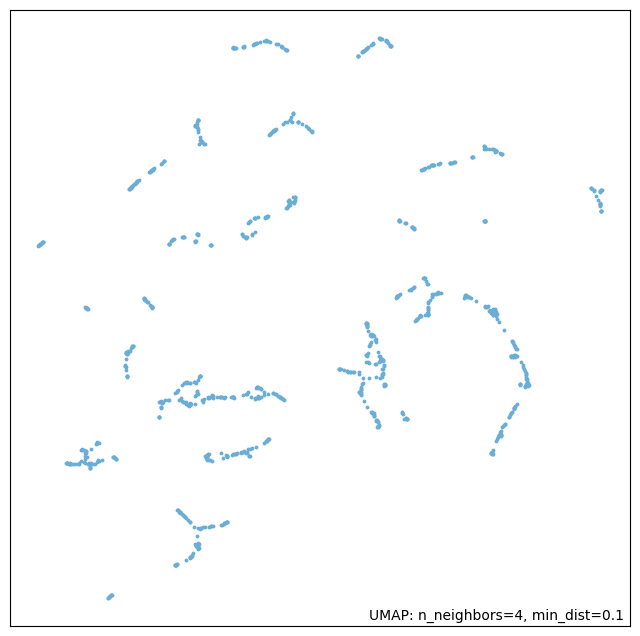

In [17]:
import umap
import umap.plot
from sklearn.neighbors import NearestNeighbors

nbrs = NearestNeighbors(n_neighbors=4, metric='euclidean')
nbrs.fit(evo_mean_train_embeddings)
knn_dists, knn_indices = nbrs.kneighbors(evo_mean_train_embeddings)

reducer = umap.umap_.UMAP(
        n_neighbors=4,
        min_dist=0.1,
        n_components=2,
        metric='euclidean',
        random_state=0,
    )

mapper = reducer.fit(evo_mean_train_embeddings, knn_indices=knn_indices, knn_dists=knn_dists)

umap.plot.points(mapper)

**We can now create a model to predict mRFP expression based on the embeddings produced by Evo 2**

In [23]:
evo_regr_linear = LinearRegression().fit(evo_mean_train_embeddings, train_data["Value"].to_numpy())
predicted_evo_linear = evo_regr_linear.predict(evo_mean_test_embeddings)

In [18]:
evo_regr = MLPRegressor(random_state=0, max_iter=2000, tol=0.001, activation='relu', verbose=True, batch_size=16, hidden_layer_sizes=(256, 128, 64))
evo_regr.fit(evo_mean_train_embeddings, train_data["Value"].to_numpy())
predicted_evo_mlp = evo_regr.predict(evo_mean_test_embeddings)

Iteration 1, loss = 26.43239951
Iteration 2, loss = 0.41238988
Iteration 3, loss = 0.25604452
Iteration 4, loss = 0.25539446
Iteration 5, loss = 0.25773668
Iteration 6, loss = 0.25931123
Iteration 7, loss = 0.25640049
Iteration 8, loss = 0.25818206
Iteration 9, loss = 0.25823200
Iteration 10, loss = 0.25820273
Iteration 11, loss = 0.25592609
Iteration 12, loss = 0.25455242
Iteration 13, loss = 0.26042200
Iteration 14, loss = 0.25887612
Training loss did not improve more than tol=0.001000 for 10 consecutive epochs. Stopping.


MLPRegressor(batch_size=16, hidden_layer_sizes=(256, 128, 64), max_iter=2000,
             random_state=0, tol=0.001, verbose=True)

In [24]:
y_true = test_data["Value"].to_numpy()
spearmanr_metric = evaluate.load("spearmanr")
pearson_metric = evaluate.load("pearsonr")
results_spearman = spearmanr_metric.compute(references=y_true, predictions=predicted_evo_linear)
result_pearson = pearson_metric.compute(references=y_true, predictions=predicted_evo_linear)
print(f"Spearman: {results_spearman['spearmanr']}")
print(f"Pearson: {result_pearson['pearsonr']}")

Spearman: 0.1805874941771462
Pearson: 0.16612412555806086
